## Quantum Teleportation

Quantum teleportation is:
- not an actual movement of a qubit from one place to another
- the only way to "copy" information from one qubit to another, see the "No Cloning Theorem" (essentially, if you measure a qubit to copy it, it will immediately collapse and its superposition state will be lost)
- faster than light

This circuit transfers the content of q0 to q2 via q1.  


In [1]:
# make quantum circuit
import qiskit as q

qc = q.QuantumCircuit(3, 3)  # 3 qbits mapped to 3 cbits

# set q0 to value 1
qc.x(0)
qc.barrier()
# entangle the 3 qbits
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.barrier()
# measure (collapse) and apply CX and CZ gates if needed
qc.measure([0, 1], [0, 1])
qc.barrier()
qc.cx(1, 2)
qc.cz(0, 2)
# measure q2 (which should always be 1, since it's copied from q0) to c2
qc.measure(2, 2)


qc.draw()

In [2]:
q.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# run job on the least busy IBM quantum computer

from qiskit.tools.monitor import job_monitor

provider = q.IBMQ.get_provider("ibm-q")
queued = float("inf")

for backend in [backend for backend in provider.backends() if backend.properties()]: # discard simulator
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {len(backend.properties().qubits)} qubits")
    if backend.status().pending_jobs < queued:
        queued = backend.status().pending_jobs
        backend_to_use = backend
        
print(f"\nThe chosen backend is {backend_to_use.name()}, with a queue of {backend_to_use.status().pending_jobs} jobs.")

backend = provider.get_backend(backend_to_use.name())
job = q.execute(qc, backend=backend, shots=2048)
job_monitor(job)

ibmqx2 has 13 queued and 5 qubits
ibmq_16_melbourne has 8 queued and 14 qubits
ibmq_vigo has 12 queued and 5 qubits
ibmq_ourense has 63 queued and 5 qubits
ibmq_london has 23 queued and 5 qubits
ibmq_burlington has 7 queued and 5 qubits
ibmq_essex has 8 queued and 5 qubits

The chosen backend is ibmq_burlington, with a queue of 7 jobs.
Job Status: job has successfully run


In [4]:
# run the same job on a simulator (which isn't subject to noise like a real quantum computer)

sim = q.Aer.get_backend("qasm_simulator")
job_sim = q.execute(qc, backend=sim, shots=2048)

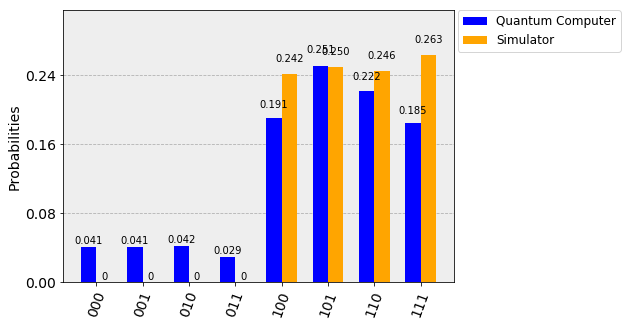

In [5]:
# plot result and see that all outcomes start with "1", where the first number is the MSB, in this case c2 (collapsed q2)

from qiskit.visualization import plot_histogram

counts_real = job.result().get_counts(qc)
counts_simulated = job_sim.result().get_counts(qc)

plot_histogram([counts_real, counts_simulated], legend=['Quantum Computer', 'Simulator'], color=['blue', 'orange'])